In [192]:
import clip
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [193]:
# use 1k compressed images
photos = pd.read_csv('photos-1k-pred.csv')
img_folder = '1k-compressed'

In [194]:
photos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   photo_id                        1000 non-null   object 
 1   photo_url                       1000 non-null   object 
 2   photo_image_url                 1000 non-null   object 
 3   photo_submitted_at              1000 non-null   object 
 4   photo_featured                  1000 non-null   object 
 5   photo_width                     1000 non-null   int64  
 6   photo_height                    1000 non-null   int64  
 7   photo_aspect_ratio              1000 non-null   float64
 8   photo_description               463 non-null    object 
 9   photographer_username           1000 non-null   object 
 10  photographer_first_name         1000 non-null   object 
 11  photographer_last_name          936 non-null    object 
 12  exif_camera_make                887

In [195]:
print(f'rows with iso null values: {photos.exif_iso.isnull().sum()}')
photos.dropna(subset=['exif_iso'], inplace=True)  # remove those rows
print('remove iso null value')
print(f'rows with iso null values: {photos.exif_iso.isnull().sum()}')

rows with iso null values: 136
remove iso null value
rows with iso null values: 0


In [196]:
# function to get a new derived column for iso
def get_iso_level(row):
    if row.exif_iso <= 200:
        return 'low'
    elif row.exif_iso <= 1000:
        return 'medium'
    else:
        return 'high'

photos['iso_level'] = photos.apply(lambda row: get_iso_level(row), axis=1)
photos.iso_level.value_counts(normalize=True)

low       0.577546
medium    0.312500
high      0.109954
Name: iso_level, dtype: float64

In [197]:
# use stratified sampling to split the train and test

X = photos.drop('iso_level', axis=1)
y = photos.iso_level

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [198]:
# sanity check for stratified sampling
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

low       0.577424
medium    0.312590
high      0.109986
Name: iso_level, dtype: float64
low       0.578035
medium    0.312139
high      0.109827
Name: iso_level, dtype: float64


In [199]:
# select device: mps for Apple M1, cuda for GPU
device = "mps" if torch.backends.mps.is_available() else "cpu"
#device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# local model and preprocessor
model, preprocess = clip.load("ViT-B/32", device=device)  # ViT-L/14@336px is the latest, ViT-B/32 is the first release, use ViT-L/14

mps


In [200]:
def get_features_clip(df, img_folder):
    all_features = []

    BATCH_SIZE = 500
    total_photos = len(df)

    for i in tqdm(range(0, total_photos, BATCH_SIZE)):
        
        # preprocess the images by batch
        images = [
            preprocess(  
                Image.open(f'./'+ img_folder + f'/{img_id}.jpg')
            ) for img_id in df['photo_id'].iloc[i:i+BATCH_SIZE]
        ]
        
        # stack the preprocess the images from list to tensor
        #image_input = torch.tensor(np.stack(images)).to(device)  
        image_input = torch.stack(images).to(device) 

        with torch.no_grad():
            image_features = model.encode_image(image_input)  # encode image
            #print(image_features.shape)  # BATCH_SIZE, 512
            all_features.append(image_features)  # append encoding result for each batch
    
    return torch.cat(all_features).cpu().numpy()  # concatenate all features

In [201]:
# only extract features when not done yet for clip
if not os.path.exists('sklearn-features/train_features_clip.npy'):
    train_features_clip = get_features_clip(X_train, img_folder)
    test_features_clip = get_features_clip(X_test, img_folder)

    # save the features
    np.save('sklearn-features/train_features_clip.npy', train_features_clip)
    np.save('sklearn-features/test_features_clip.npy', test_features_clip)
else:
    train_features_clip = np.load('sklearn-features/train_features_clip.npy')
    test_features_clip = np.load('sklearn-features/test_features_clip.npy')

In [203]:
# Evaluate using a random forest classifier

rf_cls = RandomForestClassifier()
rf_cls.fit(train_features_clip, y_train)

y_pred = rf_cls.predict(test_features_clip)
y_pred_baseline = y_test.replace(['high', 'medium'], 'low')  # predict all 'low' as a baseline

accuracy = accuracy_score(y_test, y_pred)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy = {accuracy:.3f}")
print(f"Baseline Accuracy = {accuracy_baseline:.3f}")

Accuracy = 0.578
Baseline Accuracy = 0.578


In [76]:
# build a dataset with photos taken during the day vs. at night

if not os.path.exists('photos-5k-pred.csv'):
    photos = pd.read_csv('photos-5k-pred.csv')
    photos = photos[photos.taken_time.isin(['day', 'night'])]
    photos_clustering = photos.groupby('taken_time').sample(250)
    photos_clustering.taken_time.value_counts()
    photos_day = photos_clustering[photos_clustering.taken_time=='day']
    photos_night = photos_clustering[photos_clustering.taken_time=='night']
    photos_clustering.to_csv('photos-clustering.csv', index=False)
else:
    photos_clustering = pd.read_csv('photos-clustering.csv')
    photos_day = photos_clustering[photos_clustering.taken_time=='day']
    photos_night = photos_clustering[photos_clustering.taken_time=='night']

In [204]:
# copy the selected images to clustering-photos folder
import shutil
if len(os.listdir('./clustering-photos/all/')) == 0:  # only do this when the folder is empty
    print('copy photos')
    for id in photos_clustering.photo_id:
        shutil.copy2('5k-compressed/' + id + '.jpg', 'clustering-photos/all')

    for id in photos_day.photo_id:
        shutil.copy2('5k-compressed/' + id + '.jpg', 'clustering-photos/day')

    for id in photos_night.photo_id:
        shutil.copy2('5k-compressed/' + id + '.jpg', 'clustering-photos/night')

In [230]:
# get features for all clustering photos clip

if not os.path.exists('sklearn-features/clustering_features_clip.npy'):
    all_features_clip = get_features_clip(photos_clustering, 'clustering-photos/all')
    np.save('sklearn-features/clustering_features_clip.npy', all_features_clip)
else:
    all_features_clip = np.load('sklearn-features/clustering_features_clip.npy')

In [236]:
# Kmeans Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')

inertia_scores = []
silhouette_scores = []

# try 9 different k values
# note that we have to start with 2 clusters for the silhouette score to work
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(all_features_clip)
    silhouette_scores.append(silhouette_score(all_features_clip, kmeans.labels_)) # record the silhouette score for each k
    inertia_scores.append(kmeans.inertia_) # record the inertia for each k

Text(0, 0.5, 'Silhouette scores')

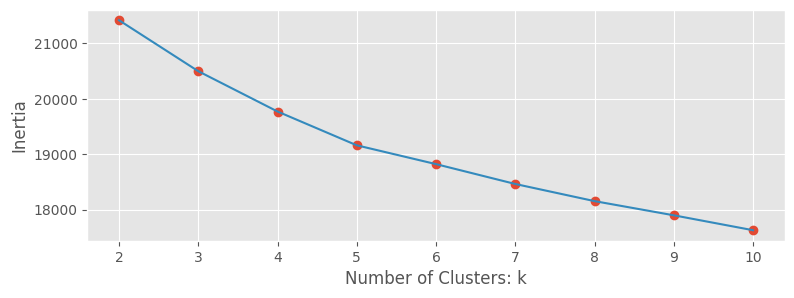

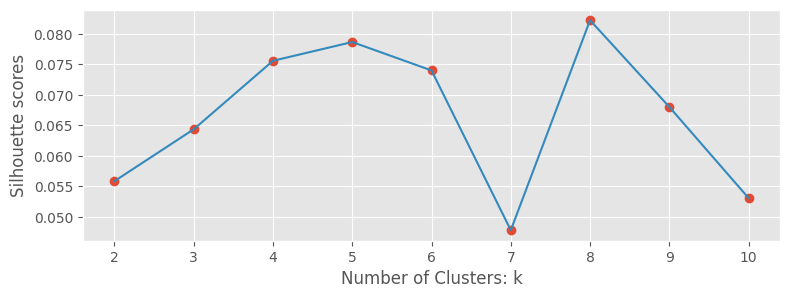

In [239]:
# plot the inertia scores
fig, ax = plt.subplots(figsize=(9, 3))
k = np.arange(2, 11) 
ax.plot(k, inertia_scores, 'o')  # draw the dots
ax.plot(k, inertia_scores, '-')  # draw the lines
ax.set_xlabel('Number of Clusters: k')
ax.set_ylabel('Inertia')

# plot the silhouette scores
fig, ax = plt.subplots(figsize=(9, 3))
k = np.arange(2, 11) 
ax.plot(k, silhouette_scores, 'o')  # draw the dots
ax.plot(k, silhouette_scores, '-')  # draw the lines
ax.set_xlabel('Number of Clusters: k')
ax.set_ylabel('Silhouette scores')

In [207]:
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
kmeans.fit(all_features)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [208]:
labels = pd.DataFrame(kmeans.labels_, columns=['cluster'])

In [209]:
df = pd.concat((photos, labels), axis=1)

In [210]:
df.cluster.value_counts()

0.0    339
1.0    161
Name: cluster, dtype: int64

In [211]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # for 2D visualization
all_features_pca = pca.fit_transform(all_features_clip)
all_features_pca = pd.DataFrame(all_features_pca, columns=['x', 'y'])
all_features_pca.head()

,x,y
0,-1.066231,1.889991
1,-2.843014,-0.348366
2,-0.451213,1.540107
3,-2.042562,2.344389
4,0.135721,1.196299


In [212]:
cluster_df = pd.concat((photos.photo_id, all_features_pca, labels), axis=1)
cluster_df.head()

,photo_id,x,y,cluster
0,XMyPniM9LF0,-1.066231,1.889991,0.0
1,rDLBArZUl1c,-2.843014,-0.348366,0.0
2,cNDGZ2sQ3Bo,-0.451213,1.540107,0.0
3,iuZ_D1eoq9k,-2.042562,2.344389,0.0
4,BeD3vjQ8SI0,0.135721,1.196299,0.0


In [213]:
import timm
#timm.list_models(pretrained=True)  # check all pretrained weights
model = timm.create_model('efficientnet_b4', pretrained=True).to(device)

In [214]:
import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

transform = create_transform(224)  # (3, 224, 224)

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)
img = Image.open(filename).convert('RGB')
tensor = transform(img) # transform and add batch dimension

In [216]:
images = [
    transform(  
        Image.open(f'./'+ img_folder + f'/{img_id}.jpg')
    ) for img_id in photos['photo_id'].iloc[0:2]
]

In [217]:
images[0].shape

torch.Size([3, 224, 224])

In [218]:
image_input = torch.stack(images).to(device) 
image_input.shape

torch.Size([2, 3, 224, 224])

In [222]:
# 1000 class features
with torch.no_grad():
    image_features = model(image_input).to(device)

image_features.shape

torch.Size([2, 1000])

In [223]:
# remove the classification layer
with torch.no_grad():
    image_features = model.forward_features(image_input).to(device)

image_features.shape

torch.Size([2, 1792, 7, 7])

In [224]:
# only keep the first two dimensions
image_features[:, :, 0, 0].shape

torch.Size([2, 1792])

In [225]:
# convert grayscale images to RGB
# used in the following function
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [226]:
def get_features_en(df, img_folder):  # get features via EfficientNet
    all_features = []

    BATCH_SIZE = 500
    total_photos = len(df)

    for i in tqdm(range(0, total_photos, BATCH_SIZE)):
        
        # preprocess the images by batch
        images = [
            transform(  
                pil_loader(f'./'+ img_folder + f'/{img_id}.jpg')
            ) for img_id in df['photo_id'].iloc[i:i+BATCH_SIZE]
        ]
        
        # stack the preprocess the images from list to tensor
        #image_input = torch.tensor(np.stack(images)).to(device)  
        image_input = torch.stack(images).to(device) 

        with torch.no_grad():
            image_features = model.forward_features(image_input)  # encode image 1792 features
            image_features = image_features[:, :, 0, 0]  # only the first two dimensions
            all_features.append(image_features)  # append encoding result for each batch
    
    return torch.cat(all_features).cpu().numpy()  # concatenate all features

In [228]:
# only extract features when not done yet for EfficientNet
if not os.path.exists('sklearn-features/train_features_en.npy'):
    train_features_en = get_features_en(X_train, img_folder)
    test_features_en = get_features_en(X_test, img_folder)

    # save the features
    np.save('sklearn-features/train_features_en.npy', train_features_en)
    np.save('sklearn-features/test_features_en.npy', test_features_en)
else:
    train_features_en = np.load('sklearn-features/train_features_en.npy')
    test_features_en = np.load('sklearn-features/test_features_en.npy')

100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


In [187]:
train_features_en.shape, test_features_en.shape

(691, 1792)

In [191]:
# Evaluate using a random forest classifier

rf_cls = RandomForestClassifier()
rf_cls.fit(train_features_en, y_train)

y_pred = rf_cls.predict(test_features_en)
y_pred_baseline = y_test.replace(['high', 'medium'], 'low')  # predict all 'low' as a baseline

accuracy = accuracy_score(y_test, y_pred)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy = {accuracy:.3f}")
print(f"Baseline Accuracy = {accuracy_baseline:.3f}")

Accuracy = 0.561
Baseline Accuracy = 0.578


In [240]:
# get features for all clustering photos en

if not os.path.exists('sklearn-features/clustering_features_en.npy'):
    all_features_en = get_features_en(photos_clustering, 'clustering-photos/all')
    np.save('sklearn-features/clustering_features_en.npy', all_features_en)
else:
    all_features_en = np.load('sklearn-features/clustering_features_en.npy')

100%|██████████| 1/1 [00:32<00:00, 32.03s/it]


In [245]:
len(all_features_en[0])

1792